In [1]:
from PIL import Image
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from utils.Scorer import Scorer
from utils.Model import Model
import time
import gc
load_dotenv()
!ollama list

NAME                ID              SIZE      MODIFIED     
qwen2.5vl:3b        fb90415cde1e    3.2 GB    29 hours ago    
moondream:latest    55fc3abd3867    1.7 GB    2 days ago      
llava:latest        8dd30f6b0cb1    4.7 GB    2 days ago      


In [2]:
PROMPTS = [
    "Provide a very short, concise, and factual caption for this image. Maximum 10 words."
]

# Images
dataset_root = Path(os.getenv("DATASET_PATH", "."))
IMG_FOLDER = dataset_root / "val2017"
NUM_IMG = 2
print(IMG_FOLDER)
IMGS_PATH = list(IMG_FOLDER.rglob('*.jpg'))[:NUM_IMG]
print(IMGS_PATH)
# Test images
IMG_TEST_PATH = IMGS_PATH[0]
IMG_TEST_ID = int(Path(IMG_TEST_PATH).stem)

# CHAIR
PATH_INSTANCES = dataset_root / "annotations/instances_val2017.json"

print(PATH_INSTANCES)
PATH_SYNONYMS = "utils/our_data/coco_synonyms_SOTA.txt"

models_list = os.getenv("AVAILABLE_MODELS", "").split(",")
print(models_list)

[PosixPath('/mnt/2210B8B210B88E73/Desktop/IA_Image/coco2017/val2017/000000000139.jpg'), PosixPath('/mnt/2210B8B210B88E73/Desktop/IA_Image/coco2017/val2017/000000000285.jpg')]
/mnt/2210B8B210B88E73/Desktop/IA_Image/coco2017/annotations/instances_val2017.json
['llava', 'moondream', 'qwen2.5vl:3b']


## UTILS

Load captions for each picture.

In [3]:
CAPTIONS_MAP_PATH = Path("utils/our_data/captions_map.pkl")

if not os.path.exists(CAPTIONS_MAP_PATH):
    print("Fichier introuvable.")
else:
    with open(CAPTIONS_MAP_PATH, "rb") as f:
        coco_captions = pickle.load(f)
        print(f"ground truth captions loaded : {len(coco_captions)}")

ground truth captions loaded : 5000


# Model

In [4]:
model_inst = {}

#print(model_inst)


# METRIQUES

In [5]:
scorer = Scorer(path_instances=PATH_INSTANCES, path_synonyms=PATH_SYNONYMS)

In [6]:
for i  in model_inst:
    print(i)


In [7]:
!java -version

openjdk version "1.8.0_472"
OpenJDK Runtime Environment (build 1.8.0_472-8u472-ga-1~24.04-b08)
OpenJDK 64-Bit Server VM (build 25.472-b08, mixed mode)


# Comparer prompts

In [8]:
model_scores = {}
for name in models_list:
    gc.collect()
    print(f"start of model :{name}")
    model = Model(model_name=name, prompts=PROMPTS, imgs_path=IMGS_PATH, coco_captions=coco_captions)

    model_scores[name] = {}

    start_time = time.time()
    model_responses, gt_captions_dict = model.execute(prompt_id=0, freq_print=0)

    print(f"DEBUG - Res sample: {list(model_responses.values())[:2]}")
    results = scorer.compute_scores(gt_captions_dict, model_responses)
    duration = time.time() - start_time
    model_scores[name] = {
            metric: score
            for metric, score in results.items()
            if metric not in ['Bleu_2', 'Bleu_3', 'Bleu_4']
        }
    model_scores[name]['Execution_Time'] = round(duration/NUM_IMG, 2)
    del model
    gc.collect()
    print(f"End model: {name}")

End model: qwen2.5vl:3b


In [9]:
print(model_scores)

{'llava': {'CIDEr': np.float64(0.8103760471858491), 'Bleu_1': 0.39726824295367413, 'METEOR': 0.1833206929923413, 'SPICE': np.float64(0.15846153846153846), 'CHAIR': 0.0, 'Execution_Time': 162.71}, 'moondream': {'CIDEr': np.float64(0.1837333256442068), 'Bleu_1': 0.31088591927878945, 'METEOR': 0.22288153575628225, 'SPICE': np.float64(0.0588235294117647), 'CHAIR': 0.0, 'Execution_Time': 69.86}, 'qwen2.5vl:3b': {'CIDEr': np.float64(0.0), 'Bleu_1': 0.8668778995025025, 'METEOR': 0.3616426463260509, 'SPICE': np.float64(0.23076923076923075), 'CHAIR': 0.0, 'Execution_Time': 93.54}}


In [10]:
import matplotlib.pyplot as plt
import math

def plot_model_comparison(model_scores):
    # On récupère toutes les métriques disponibles
    first_key = next(iter(model_scores))
    metrics = [k for k in model_scores[first_key].keys()]

    model_names = list(model_scores.keys())
    x_labels = model_names

    n_metrics = len(metrics)
    n_cols = 2
    n_rows = math.ceil(n_metrics / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

    # Gestion du cas où il n'y a qu'une seule métrique (axes n'est pas une liste)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        scores = [model_scores[m_name][metric] for m_name in model_names]



        is_time = "Time" in metric or "temp" in metric.lower()
        color = 'lightcoral' if is_time else 'skyblue'

        bars = ax.bar(x_labels, scores, color=color, edgecolor='black')

        # Titre et Label
        title_suffix = " (Secondes)" if is_time else ""
        ax.set_title(f"{metric}{title_suffix}", fontsize=14, fontweight='bold')
        ax.set_ylabel("Temps (s)" if is_time else "Score")

        ax.grid(axis='y', linestyle='--', alpha=0.7)


        for bar in bars:
            height = bar.get_height()
            # On affiche 2 décimales pour les scores, 3 pour le temps par image
            fmt = '.3f' if "per_Img" in metric else '.2f'
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    f'{height:{fmt}}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Supprimer les graphiques vides si n_metrics est impair
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

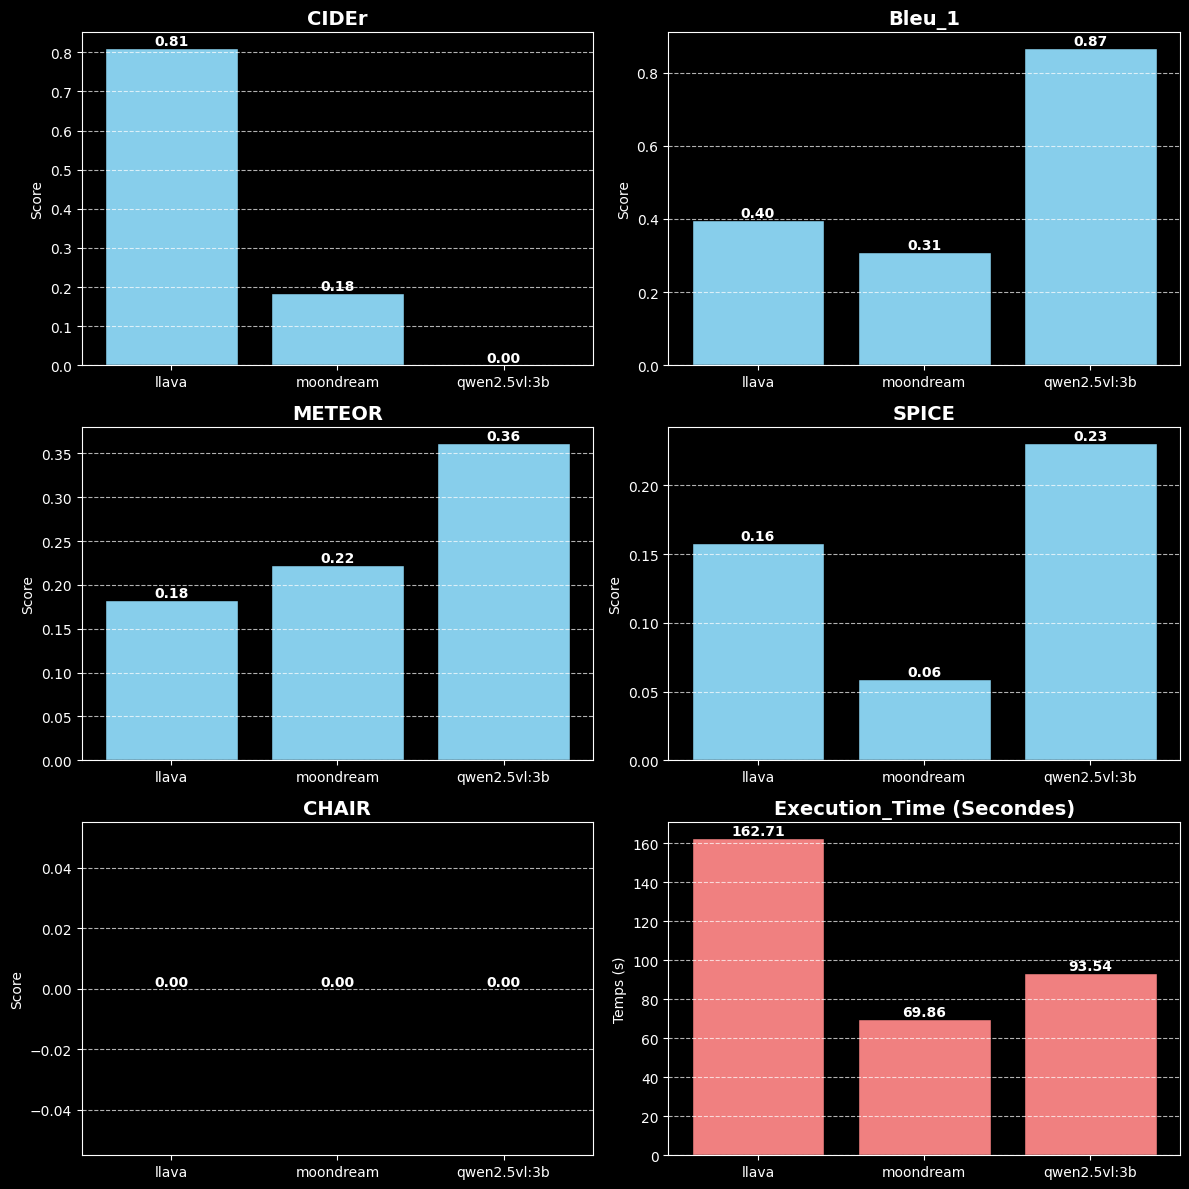

In [11]:
plot_model_comparison(model_scores)